# Part II: The Power of Federated Learning for Network Security

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/phdcybersec/nof_2023/blob/main/notebooks/part2.ipynb)

In this second part, we will look at FL as a solution to the problem of sharing network data to train IDSs. We will use NSL-KDD, a commonly used (and sometimes criticized) dataset for training IDSs, and a simple neural network architecture to train our model. The IDS use case involves NIID data, so we will also see how FL can be used to *share knowledge* between different institutions.

## Section 0: Prerequisites

### Dependencies

First, let's make sure that the correct dependencies are installed. If you are running this notebook locally, please see the README for instructions on how to install the appropriate dependencies. If you are running this notebook on Google Colab, you can run the following cell:

In [1]:
# check if we are running on Google Colab
import os
from IPython.core.getipython import get_ipython

if "google.colab" in str(get_ipython()):
    !git clone https://github.com/phdcybersec/nof_2023.git
    %pip install poetry
    %pip install -r <(poetry export -C nof_2023/)
    !rm -r nof_2023/
else:
    # if not, we assume we are running on a local machine were dependencies are already
    # installed; cd to a temporary directory to avoid cluttering the current directory
    
    try:
        os.mkdir("/tmp/nslkdd")
    except FileExistsError:
        pass
    os.chdir("/tmp/nslkdd")

# download the dataset
if not os.path.exists("nslkdd/KDDTrain+.txt"):
    !curl -Lo nslkdd.zip http://205.174.165.80/CICDataset/NSL-KDD/Dataset/NSL-KDD.zip
    !unzip -o -d nslkdd nslkdd.zip && rm nslkdd.zip
    

Now that we have all dependencies installed, we can import everything we need for this tutorial:

In [2]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import functools
import math
from collections import OrderedDict
from typing import cast, Callable

import flwr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from flwr.common import Metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from numpy.typing import ArrayLike, NDArray
from flwr.simulation.ray_transport.utils import enable_tf_gpu_growth
from tensorflow import keras
from flwr.server.history import History
from flwr.common import ndarrays_to_parameters, parameters_to_ndarrays
from flwr.server.strategy import FedAvg

...and check that everything is working as expected. If you have access to a GPU, either on Colab on on your local machine, it should be detected and used by TensorFlow. We also use a Flower utility function to allow TensorFlow to share the GPU memory between multiple processes, which is necessary for running multiple clients in parallel.

In [3]:
print("TensorFlow version:", tf.__version__)
print(f"Num GPUs Available: {len(tf.config.list_physical_devices('GPU'))}")
enable_tf_gpu_growth()

TensorFlow version: 2.10.1
Num GPUs Available: 2


To allow others to reproduce your results with certitude, set a seed for all the pseudo-random number generators (PRNG) that you use. You should also run your threads deterministically, in case your ML backend optimize training. This will have a negative impact on the performance. On TensorFlow: 

In [4]:
SEED = 1138
keras.utils.set_random_seed(SEED)
tf.config.experimental.enable_op_determinism()

### Section 1: Data exploration and partitioning

In this section, we will explore the NSL-KDD dataset and partition it into train and test sets. We will also create a function to generate IID and NIID data partitions.

NSL-KDD is a set of network flows that have been labeled as either "normal" or one of the 22 attack clasees. The dataset is actually a modified version of the original KDD Cup 1999 dataset, which has been criticized for containing duplicate records and for not being representative of modern network traffic. 

NSL-KDD is a newer version of the dataset that addresses these issues. It is commonly used for training IDSs, but is still made of outdated data. For FL experiment however, it is interesting because of the amount of resources on this dataset in the literature.

We will focus on binary classification in this demonstration. Thus, we need to map the current labels to two classes: either benign or malicious. Since the ML model will only work with numerical values, benign becomes `0` and malicious `1`. 

In [5]:
def load_nslkdd() -> (
    tuple[
        tuple[pd.DataFrame, pd.DataFrame, pd.Series],
        tuple[pd.DataFrame, pd.DataFrame, pd.Series],
    ]
):
    # column names:
    # https://github.com/kahramankostas/NSL-KDD-binary-classification-with-Transformer#reading-csv-files
    c_names = [
        "duration",
        "protocol_type",
        "service",
        "flag",
        "src_bytes",
        "dst_bytes",
        "land",
        "wrong_fragment",
        "urgent",
        "hot",
        "num_failed_logins",
        "logged_in",
        "num_compromised",
        "root_shell",
        "su_attempted",
        "num_root",
        "num_file_creations",
        "num_shells",
        "num_access_files",
        "num_outbound_cmds",
        "is_host_login",
        "is_guest_login",
        "count",
        "srv_count",
        "serror_rate",
        "srv_serror_rate",
        "rerror_rate",
        "srv_rerror_rate",
        "same_srv_rate",
        "diff_srv_rate",
        "srv_diff_host_rate",
        "dst_host_count",
        "dst_host_srv_count",
        "dst_host_same_srv_rate",
        "dst_host_diff_srv_rate",
        "dst_host_same_src_port_rate",
        "dst_host_srv_diff_host_rate",
        "dst_host_serror_rate",
        "dst_host_srv_serror_rate",
        "dst_host_rerror_rate",
        "dst_host_srv_rerror_rate",
        "label",
        "difficulty",
    ]

    # load datasets
    train_df = pd.read_csv("./nslkdd/KDDTrain+.txt", names=c_names)
    test_df = pd.read_csv("./nslkdd/KDDTest+.txt", names=c_names)

    # extract the labels for the outputs (will serve as metadata)
    m_train = train_df["label"]
    m_test = test_df["label"]

    # drop labels for input, and difficulty
    train_df = train_df.drop(columns=["label", "difficulty"])
    test_df = test_df.drop(columns=["label", "difficulty"])

    # convert classes to numerical values
    X_train = pd.get_dummies(train_df)
    X_test = pd.get_dummies(test_df)

    # reindex the testing dataset so its columns match the training columns
    X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

    # normalize input dataframes
    scaler = MinMaxScaler()
    scaler.fit(X_train)
    X_train[X_train.columns] = scaler.transform(X_train)
    X_test[X_test.columns] = scaler.transform(X_test)

    # transform outputs to binary classification
    y_train = m_train.apply(lambda x: False if x == "normal" else True)
    y_test = m_test.apply(lambda x: False if x == "normal" else True)

    # apply one-hot encoding to outputs
    y_train = pd.get_dummies(y_train, prefix="Malicious")
    y_test = pd.get_dummies(y_test, prefix="Malicious")

    return (X_train, y_train, m_train), (X_test, y_test, m_test)

In [6]:
(X_train, y_train, m_train), (X_test, y_test, m_test) = load_nslkdd()

print("Number of features:", len(X_train.columns))
print("Length of training set:", len(X_train))
print("Length of testing set:", len(X_test))
print(f"Label distribution in testing set:\n{m_test.value_counts()}")

Number of features: 122
Length of training set: 125973
Length of testing set: 22544
Label distribution in testing set:
label
normal             9711
neptune            4657
guess_passwd       1231
mscan               996
warezmaster         944
apache2             737
satan               735
processtable        685
smurf               665
back                359
snmpguess           331
saint               319
mailbomb            293
snmpgetattack       178
portsweep           157
ipsweep             141
httptunnel          133
nmap                 73
pod                  41
buffer_overflow      20
multihop             18
named                17
ps                   15
sendmail             14
rootkit              13
xterm                13
teardrop             12
xlock                 9
land                  7
xsnoop                4
ftp_write             3
worm                  2
loadmodule            2
perl                  2
sqlattack             2
udpstorm              2
phf        

In [7]:
ATTACK_LABELS = m_train.unique()[m_train.unique() != "normal"]
print(f"Attack labels: {ATTACK_LABELS}")

Attack labels: ['neptune' 'warezclient' 'ipsweep' 'portsweep' 'teardrop' 'nmap' 'satan'
 'smurf' 'pod' 'back' 'guess_passwd' 'ftp_write' 'multihop' 'rootkit'
 'buffer_overflow' 'imap' 'warezmaster' 'phf' 'land' 'loadmodule' 'spy'
 'perl']


In [8]:
y_test["Malicious_True"].value_counts()

Malicious_True
True     12833
False     9711
Name: count, dtype: int64

## Section 2: Training on local data

In [9]:
BATCH_SIZE = 128
NUM_EPOCHS = 10
NUM_CLIENTS = 10
NUM_ROUNDS = 10

Here we use a DNN architecture with 2 hidden layers of 64 neurons each. We use the Adam optimizer with a learning rate of 0.001 and the binary cross-entropy loss function. We train the model for 10 epochs with a batch size of 128. The "dropout" layers are used to prevent overfitting by randomly dropping some neurons during training.

This is a typical architecture for this use case that you can use for netflow classification tasks.

In [10]:
n_features = X_train.shape[1]
print(n_features)


def mk_model() -> keras.Model:
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.Dense(64, activation="relu", input_shape=(n_features,)),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(64, activation="relu"),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Dense(2, activation="softmax"),
        ]
    )

    model.compile(
        loss="categorical_crossentropy",
        optimizer="adam",
        metrics=["accuracy"],
    )
    return model


mk_model().summary()

122
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                7872      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 130       
                                                                 
Total params: 12,162
Trainable params: 12,162
Non-trainable params: 0
_________________________________________________________________


Since IDS are typically a NIID use case, we will also create a function to generate NIID data partitions. This function will be used later to generate the data for the FL experiment.

We will also need a more evolved evaluation method for this use case, as we want to see how well the model performs on each attack class.

In [11]:
# Only keep attacks that are well detected
# (d["rate"] > 0.5) & (d["count"] > 100)
DROPABLE_CLASSES = [
    "neptune",
    "normal",
    "saint",
    "mscan",
    "smurf",
    "satan",
    "ipsweep",
    "portsweep",
]


def partition(
    num_shards: int,
    dataset: tuple[pd.DataFrame, pd.DataFrame, pd.Series],
    n_drop: int = 0,
) -> list[tuple[pd.DataFrame, pd.DataFrame, pd.Series]]:
    """Partition the NSL-KDD dataset."""
    X, y, m = dataset
    partitions = []
    # We keep all partitions equal-sized in this example
    partition_size = math.floor(len(X) / num_shards)
    shuffle_idx = np.random.permutation(len(X))
    X, y, m = X.iloc[shuffle_idx], y.iloc[shuffle_idx], m.iloc[shuffle_idx]

    for i in range(num_shards):
        idx_from, idx_to = i * partition_size, (i + 1) * partition_size

        X_part = X[idx_from:idx_to]
        y_part = y[idx_from:idx_to]
        m_part = m[idx_from:idx_to]

        # randomly remove NUM_REMOVED_CLASSES from each partition
        _rm_classes = np.random.choice(DROPABLE_CLASSES, n_drop, replace=False)

        X_part = X_part[m_part.isin(_rm_classes) == False]
        y_part = y_part[m_part.isin(_rm_classes) == False]
        m_part = m_part[m_part.isin(_rm_classes) == False]

        partitions.append((X_part, y_part, m_part))
    return partitions


def get_evaluate_fn(testset):
    """Return an evaluation function for server-side (i.e. centralized) evaluation."""
    x_test, y_test, _ = testset

    # The `evaluate` function will be called after every round by the strategy
    def evaluate(
        server_round: int,
        parameters: flwr.common.NDArrays,
        config: dict[str, flwr.common.Scalar],
    ):
        if server_round == NUM_ROUNDS:
            # Save final model

            np.save("fl_weights", parameters)

        model = mk_model()  # Construct the model
        model.set_weights(parameters)  # Update model with the latest parameters
        loss, _ = model.evaluate(x_test, y_test, verbose=cast(str, 0))

        inferences = model.predict(x_test, verbose=cast(str, 0))
        y_pred = np.argmax(np.round(inferences), axis=1)
        y_true = np.argmax(y_test.to_numpy(), axis=1)

        cm = confusion_matrix(y_true, y_pred)
        tn, fp, fn, tp = cm.ravel()

        return (
            loss,
            {
                "accuracy": (tn + tp) / (tn + fp + fn + tp),
                "precision": tp / (tp + fp),
                "recall": tp / (tp + fn),
                "f1": 2 * tp / (2 * tp + fp + fn),
                "miss_rate": fn / (fn + tp),
            },
        )

    return evaluate


def eval_model(parameters, testset):
    loss, metrics = get_evaluate_fn(testset)(0, parameters, {})
    return {"loss": loss} | metrics


def eval_classes(parameters, testset, classes=None):
    X, y, m = testset
    if classes is None:
        classes = m.unique()
    model = mk_model()
    model.set_weights(parameters)
    inferences = model.predict(X)
    y_pred = np.argmax(np.round(inferences), axis=1)
    y_true = np.argmax(y.to_numpy(), axis=1)

    classes_stats = {}
    for cls in classes:
        class_filter = m == cls

        count = len(m[class_filter])
        if not (count > 0):
            continue
        correct = len(m[(class_filter) & (y_true == y_pred)])
        missed = len(m[(class_filter) & (y_true != y_pred)])

        classes_stats[cls] = {
            "count": count,
            "correct": correct,
            "missed": missed,
            "rate": correct / count,
        }

    ret = pd.DataFrame(classes_stats).T
    ret[["count", "correct", "missed"]].astype(int, copy=False)
    return ret

First, lets create one client with one partition of the data to simulate what one single organization might have access to. We start with IID distribution.

In [12]:
trainset, testset = load_nslkdd()

X, y, _ = partition(10, trainset)[0]
print(X.shape)
print(y.shape)

(12597, 122)
(12597, 2)


In [13]:
model = mk_model()
model.fit(X, y, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)

score_iid = eval_model(model.get_weights(), testset)
score_iid

Epoch 1/10
99/99 [==============================] - 2s 2ms/step - loss: 0.2882 - accuracy: 0.8915
Epoch 2/10
99/99 [==============================] - 0s 2ms/step - loss: 0.1240 - accuracy: 0.9666
Epoch 3/10
99/99 [==============================] - 0s 2ms/step - loss: 0.1054 - accuracy: 0.9711
Epoch 4/10
99/99 [==============================] - 0s 2ms/step - loss: 0.0904 - accuracy: 0.9744
Epoch 5/10
99/99 [==============================] - 0s 2ms/step - loss: 0.0842 - accuracy: 0.9753
Epoch 6/10
99/99 [==============================] - 0s 2ms/step - loss: 0.0755 - accuracy: 0.9762
Epoch 7/10
99/99 [==============================] - 0s 2ms/step - loss: 0.0725 - accuracy: 0.9770
Epoch 8/10
99/99 [==============================] - 0s 2ms/step - loss: 0.0649 - accuracy: 0.9780
Epoch 9/10
99/99 [==============================] - 0s 2ms/step - loss: 0.0599 - accuracy: 0.9786
Epoch 10/10
99/99 [==============================] - 0s 2ms/step - loss: 0.0582 - accuracy: 0.9786


{'loss': 1.1179088354110718,
 'accuracy': 0.7714247693399574,
 'precision': 0.9204072695423692,
 'recall': 0.6551079248811658,
 'f1': 0.7654208585605681,
 'miss_rate': 0.34489207511883424}

In [14]:
eval_classes(model.get_weights(), testset)

705/705 [==============================] - 1s 971us/step


,count,correct,missed,rate
neptune,4657.0,4657.0,0.0,1.000000
normal,9711.0,8984.0,727.0,0.925136
saint,319.0,307.0,12.0,0.962382
mscan,996.0,776.0,220.0,0.779116
guess_passwd,1231.0,3.0,1228.0,0.002437
smurf,665.0,665.0,0.0,1.000000
apache2,737.0,609.0,128.0,0.826323
satan,735.0,657.0,78.0,0.893878
buffer_overflow,20.0,2.0,18.0,0.100000
back,359.0,50.0,309.0,0.139276


Now, let's train the same model architecture on a more realistic use case, where a local organization might not have access to all data.

In [17]:
X, y, _ = partition(10, trainset, n_drop=4)[0]
model = mk_model()
model.fit(X, y, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
score_niid = eval_model(model.get_weights(), testset)
score_niid

Epoch 1/10
12/12 [==============================] - 0s 3ms/step - loss: 0.7500 - accuracy: 0.4550
Epoch 2/10
12/12 [==============================] - 0s 3ms/step - loss: 0.4027 - accuracy: 0.9660
Epoch 3/10
12/12 [==============================] - 0s 2ms/step - loss: 0.1755 - accuracy: 0.9993
Epoch 4/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0618 - accuracy: 1.0000
Epoch 5/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0221 - accuracy: 1.0000
Epoch 6/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0117 - accuracy: 1.0000
Epoch 7/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0069 - accuracy: 1.0000
Epoch 8/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0045 - accuracy: 1.0000
Epoch 9/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0039 - accuracy: 1.0000
Epoch 10/10
12/12 [==============================] - 0s 2ms/step - loss: 0.0031 - accuracy: 1.0000


{'loss': 3.4220774173736572,
 'accuracy': 0.5692423704755145,
 'precision': 0.5692423704755145,
 'recall': 1.0,
 'f1': 0.7254996183961331,
 'miss_rate': 0.0}

In [18]:
eval_classes(model.get_weights(), testset)

705/705 [==============================] - 1s 964us/step


,count,correct,missed,rate
neptune,4657.0,4657.0,0.0,1.0
normal,9711.0,0.0,9711.0,0.0
saint,319.0,319.0,0.0,1.0
mscan,996.0,996.0,0.0,1.0
guess_passwd,1231.0,1231.0,0.0,1.0
smurf,665.0,665.0,0.0,1.0
apache2,737.0,737.0,0.0,1.0
satan,735.0,735.0,0.0,1.0
buffer_overflow,20.0,20.0,0.0,1.0
back,359.0,359.0,0.0,1.0


## Section 3: Collaborative learning using FL

As in part I, we start with our client. This time, we will create 10 clients, each with a different partition of the data. We are closer to the cross-silo use case, where each organization is a client, with more data, more computing power, and are typically always available.

In [19]:
class FlowerClient(flwr.client.NumPyClient):
    def __init__(self, X, y):
        self.X_train = X
        self.y_train = y

        self.model = mk_model()

    def get_parameters(self, config):
        return self.model.get_weights()

    def fit(self, parameters, config):
        self.model.set_weights(parameters)
        self.model.fit(
            self.X_train,
            self.y_train,
            epochs=1,
            batch_size=BATCH_SIZE,
            validation_split=0.1,
            verbose=cast(str, 0),
        )
        return self.model.get_weights(), len(self.X_train), {}

In [20]:
def mk_client_fn(partitions):
    """Return a function which creates a new FlowerClient for a given partition."""

    def client_fn(cid: str) -> FlowerClient:
        """Create a new FlowerClient for partition i."""
        x_train, y_train, _ = partitions[int(cid)]

        return FlowerClient(x_train, y_train)  # , x_eval_cid, y_eval_cid)

    return client_fn

Finally, let's try federated learning!

In [21]:
trainset, testset = load_nslkdd()
partitions = partition(NUM_CLIENTS, trainset, n_drop=4)

strategy = FedAvg(
    fraction_fit=1.0,  # Sample 100% of available clients for training
    fraction_evaluate=0.0,  # Disable the federated evaluation
    min_fit_clients=NUM_CLIENTS,  # Always sample all clients
    min_available_clients=NUM_CLIENTS,
    evaluate_fn=get_evaluate_fn(testset),  # global evaluation function
    initial_parameters=ndarrays_to_parameters(mk_model().get_weights()),
)

# With a dictionary, you tell Flower's VirtualClientEngine that each
# client needs exclusive access to these many resources in order to run
client_resources = {
    "num_cpus": max(int((os.cpu_count() or 1) / NUM_CLIENTS), 1),
    "num_gpus": 0.0,
}

# Start simulation
history = flwr.simulation.start_simulation(
    client_fn=mk_client_fn(partitions),
    num_clients=NUM_CLIENTS,
    config=flwr.server.ServerConfig(num_rounds=NUM_ROUNDS),
    strategy=strategy,
    client_resources=client_resources,
    actor_kwargs={
        "on_actor_init_fn": enable_tf_gpu_growth  # Enable GPU growth upon actor init.
    },
    ray_init_args={"num_gpus": len(tf.config.list_physical_devices("GPU"))},
)

INFO flwr 2023-10-04 15:25:25,210 | app.py:175 | Starting Flower simulation, config: ServerConfig(num_rounds=10, round_timeout=None)
2023-10-04 15:25:28,394	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 
INFO flwr 2023-10-04 15:25:31,050 | app.py:210 | Flower VCE: Ray initialized with resources: {'CPU': 192.0, 'GPU': 2.0, 'node:__internal_head__': 1.0, 'object_store_memory': 200000000000.0, 'memory': 581037857792.0, 'node:192.168.1.240': 1.0}
INFO flwr 2023-10-04 15:25:31,051 | app.py:224 | Flower VCE: Resources for each Virtual Client: {'num_cpus': 19, 'num_gpus': 0.0}
INFO flwr 2023-10-04 15:25:31,081 | app.py:270 | Flower VCE: Creating VirtualClientEngineActorPool with 10 actors
INFO flwr 2023-10-04 15:25:31,083 | server.py:89 | Initializing global parameters
INFO flwr 2023-10-04 15:25:31,083 | server.py:272 | Using initial parameters provided by strategy
INFO flwr 2023-10-04 15:25:31,084 | server.py:91 | Evaluating initial parameters
INFO

In [22]:
fl_weights = np.load("fl_weights.npy", allow_pickle=True)
score_fl = eval_model(fl_weights, testset)
score_fl

{'loss': 0.8508135080337524,
 'accuracy': 0.7935149041873669,
 'precision': 0.9224173553719008,
 'recall': 0.6957843060858724,
 'f1': 0.7932305778883312,
 'miss_rate': 0.3042156939141276}

In [23]:
eval_classes(fl_weights, testset)

705/705 [==============================] - 1s 943us/step


,count,correct,missed,rate
neptune,4657.0,4657.0,0.0,1.000000
normal,9711.0,8960.0,751.0,0.922665
saint,319.0,307.0,12.0,0.962382
mscan,996.0,913.0,83.0,0.916667
guess_passwd,1231.0,14.0,1217.0,0.011373
smurf,665.0,665.0,0.0,1.000000
apache2,737.0,726.0,11.0,0.985075
satan,735.0,668.0,67.0,0.908844
buffer_overflow,20.0,1.0,19.0,0.050000
back,359.0,50.0,309.0,0.139276


history.metrics_centralized = {'accuracy': [(0, 0.27803406671398156), (1, 0.7885024840312278), (2, 0.7844215755855216), (3, 0.7780784244144784), (4, 0.7766146202980837), (5, 0.7781671398154719), (6, 0.7851312987934705), (7, 0.7868168914123492), (8, 0.7906760113555713), (9, 0.7941359119943222), (10, 0.7935149041873669)], 'precision': [(0, 0.3517098802653114), (1, 0.9612261237561478), (2, 0.9142678998233399), (3, 0.9125395152792413), (4, 0.9137217446673034), (5, 0.9158878504672897), (6, 0.9190181474876744), (7, 0.9207464094768844), (8, 0.9220765709529755), (9, 0.922616591002889), (10, 0.9224173553719008)], 'recall': [(0, 0.3181641081586535), (1, 0.6548741525753916), (2, 0.6855762487337334), (3, 0.6748227226681213), (4, 0.670926517571885), (5, 0.6720174549988311), (6, 0.6826930569625185), (7, 0.6844073872048625), (8, 0.6906413153588404), (9, 0.6967973194108937), (10, 0.6957843060858724)], 'f1': [(0, 0.3340970460682432), (1, 0.7790137189469781), (2, 0.7835767723548273), (3, 0.7758813779509

Text(0.5, 1.0, 'NSL-KDD - Local IID vs. Local NIID vs. Federated \n 10 clients with 10 clients per round')

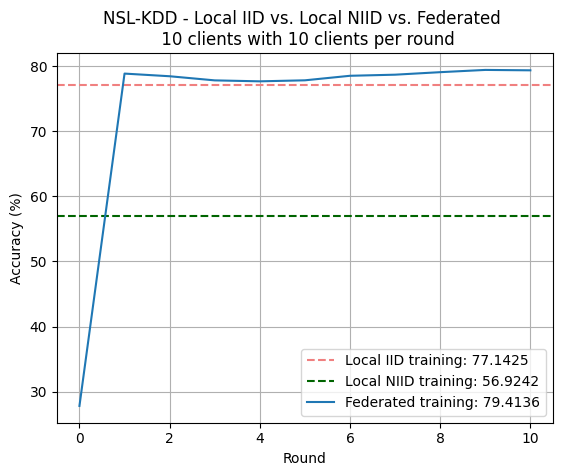

In [24]:
print(f"{history.metrics_centralized = }")

global_accuracy_centralised = cast(list, history.metrics_centralized["accuracy"])
round = [data[0] for data in global_accuracy_centralised]
acc = [100.0 * data[1] for data in global_accuracy_centralised]

iid = score_iid["accuracy"] * 100
plt.axhline(
    y=iid, label=f"Local IID training: {iid:.4f}", linestyle="--", color="lightcoral"
)
niid = score_niid["accuracy"] * 100
plt.axhline(
    y=niid, label=f"Local NIID training: {niid:.4f}", linestyle="--", color="darkgreen"
)
plt.plot(round, acc, label=f"Federated training: {max(acc):.4f}")
plt.grid()
plt.ylabel("Accuracy (%)")
plt.xlabel("Round")
plt.legend()
plt.title(
    "NSL-KDD - Local IID vs. Local NIID vs. Federated \n 10 clients with 10 clients per"
    " round"
)